# FastSAM
<a target="_blank" href="https://colab.research.google.com/github/mora-bprs/SAM-model/blob/thuva/fastSAM.ipynb">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The following models are evaluated in this notebook to compare and contrast their efficacy to the bin picking task
1. SAM
2. FastSAM
2. FastSAM-s
<!-- TODO: add more details about the models -->

___
# 1. Environment Setup
---

In [1]:
import os
import gdown
import shutil

###############
COLAB = False  # True if Google Colab
###############
#####################
INITIALIZED = True  # False if running for the first time
#####################
######################
TESTING_SAM = True  # WIP: True if testing SAM, warn!: processing time and data usage
######################

# Other Configurations
#######################
DETAILED_LOGS = True  # True for detailed logs
DEFAULT_COLORS = False  # True for not overriding your colors
RESET_FASTSAM = False  # True to reset FastSAM repo
RESET_DATASET = False  # True to reset box_train dataset
RESET_WEIGHTS = False  # True to reset weights
#######################


def log(*args):
    if DETAILED_LOGS:
        print("log:", *args)


if COLAB:
    if not os.system("pip install yachalk"):
        log("yachalk installed")
else:
    if not os.system("pip install -r requirements.txt"):
        log("local pip requirements installed")

from yachalk import chalk as c  # noqa: E402

c.enable_full_colors()

by = c.bold.yellow_bright if DEFAULT_COLORS else c.bold.hex("#f0deb2")
br = c.bold.red_bright if DEFAULT_COLORS else c.bold.hex("#df8ca4")
bg = c.bold.green_bright if DEFAULT_COLORS else c.bold.hex("#abd6a0")
bb = c.bold.blue_bright if DEFAULT_COLORS else c.bold.hex("#92b3f4")
bm = c.bold.magenta_bright if DEFAULT_COLORS else c.bold.hex("#dcb6d6")
bc = c.bold.cyan_bright if DEFAULT_COLORS else c.bold.hex("#9cdae9")
bp = c.bold.hex("#c5a7f2")

print(by("Google Colab") if COLAB else bm("Local"), "Environment Configured")
ROOT = os.getcwd() if not COLAB else "/content"
print(bc("Working Directory:"), ROOT)

log: local pip requirements installed
Local Environment Configured
Working Directory: /Users/tony/dev/SAM-model


In [2]:
# download FastSAM
if RESET_FASTSAM or not os.path.exists("lib/FastSAM"):
    if os.path.exists("lib/FastSAM"):
        shutil.rmtree("lib/FastSAM", ignore_errors=False)
    if not os.system(
        "git clone https://github.com/CASIA-IVA-Lab/FastSAM.git lib/FastSAM"
    ):
        log(bg("FastSAM repository cloned"))
else:
    print("skipping: FastSAM already downloaded")

if TESTING_SAM:
    log(bg("installing SAM dependencies"))
    if not os.system("pip install onnx onnxruntime"):
        log(bg("onnx and onnxruntime installed"))
    if not os.system(
        "pip install 'git+https://github.com/facebookresearch/segment-anything.git'"
    ):
        log(bg("segment-anything installed"))

if COLAB:
    if not os.system("pip install segment-anything-fast"):
        log(bg("segment-anything-fast installed"))
if not INITIALIZED:
    if not os.system("pip install -r lib/FastSAM/requirements.txt"):
        log(bg("FastSAM requirements installed"))
else:
    print(by("skipping: dependencies already installed"))

Skipping: FastSAM already downloaded
log: Installing SAM dependencies
log: onnx and onnxruntime installed
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/2j/pvqqyvg55vdb3xz5tmq6gc2h0000gn/T/pip-req-build-n74mmw4l


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/2j/pvqqyvg55vdb3xz5tmq6gc2h0000gn/T/pip-req-build-n74mmw4l


  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
log: segment-anything installed
Skipping: Dependencies already installed


In [3]:
import cv2
import numpy as np
import torch
import torchvision
from matplotlib import patches, pyplot as plt
from random import randint


print(f"{by('PyTorch')} v{torch.__version__}")
print(f"{by('Torchvision')} v{torchvision.__version__}")
print(f"{by('OpenCV')} v{cv2.__version__}")
CUDA = torch.cuda.is_available()
MPS = torch.backends.mps.is_available()
print(f"{bg('CUDA')} Available: {bg(CUDA) if CUDA else br(CUDA)}")
print(f"{bb('MPS')} Available: {bg(MPS) if MPS else br(MPS)}")

# TODO: check for CUDA and MPS and handle device accordingly for SAM and FastSAM
device = "cuda" if CUDA else "cpu"

PyTorch v2.3.0
Torchvision v0.18.0
OpenCV v4.9.0
CUDA Available: False
MPS Available: True


## Test dataset setup

In [4]:
if not os.path.exists("train") or RESET_DATASET:
    shutil.rmtree("train", ignore_errors=True)
    gdown.download(
        "https://drive.google.com/uc?id=1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc",
        "box_train.zip",
        quiet=False,
    )
    os.system("unzip box_train.zip")
    os.remove("box_train.zip")
else:
    print(bg("skipping: dataset already downloaded"))

DATASET_PATH = f"{ROOT}/train"

if not os.path.exists(f"{ROOT}/annotate"):
    os.mkdir(f"{ROOT}/annotate")

Skipping: Dataset already downloaded


## Pretrained weights setup

In [5]:
### downloading FastSAM weights (pretrained model checkpoints)
# two model versions of the model are available with different sizes.
# `FastSAM` will be referred as `FastSAM-x` (https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view)
# `FastSAM-s` (https://drive.google.com/file/d/10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV/view)


if RESET_WEIGHTS:
    if os.path.exists("weights/FastSAM-s.pt"):
        os.remove("weights/FastSAM-s.pt")
    if os.path.exists("weights/FastSAM-x.pt"):
        os.remove("weights/FastSAM-x.pt")
    if os.path.exists("weights/sam_vit_h_4b8939.pt"):
        os.remove("weights/sam_vit_h_4b8939.pt")
if not os.path.exists(f"{ROOT}/weights"):
    os.mkdir(f"{ROOT}/weights")
if not os.path.exists("weights/FastSAM-s.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV",
        "weights/FastSAM-s.pt",
        quiet=False,
    )
if not os.path.exists("weights/FastSAM-x.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv",
        "weights/FastSAM-x.pt",
        quiet=False,
    )
print(bg("FastSAM Weights Configured"))

if TESTING_SAM
    if not os.path.exists("weights/sam_vit_h_4b8939.pt"):
        print(br("Downloading SAM weights (this may take a while...)"))
        if not os.system(
            "wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights/"
        ):
            print(bg("SAM weights downloaded"))
    else:
        print(by("skipping: SAM weights already downloaded"))

FastSAM Weights Configured


--2024-04-27 09:33:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.111.125, 18.239.111.129, 18.239.111.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.111.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘weights/sam_vit_h_4b8939.pth’

     0K .......... .......... .......... .......... ..........  0%  338K 2h3m
    50K .......... .......... .......... .......... ..........  0% 3.52M 67m38s
   100K .......... .......... .......... .......... ..........  0%  909K 60m23s
   150K .......... .......... .......... .......... ..........  0% 1.99M 50m24s
   200K .......... .......... .......... .......... ..........  0% 3.02M 43m2s
   250K .......... .......... .......... .......... ..........  0% 1.48M 40m26s
   300K .......... .......... .......... .......... ..........  0% 2.72M 36m48s
  

SAM weights downloaded


........ .......... .......... .......... .......... 99% 2.06M 0s
2503950K .......... .......... .......... .......... .......... 99% 3.37M 0s
2504000K .......... .......... .......... .......... .......... 99% 2.50M 0s
2504050K .......... .......... .......... .......... .......... 99% 4.12M 0s
2504100K .......... .......... .......... .......... .......... 99% 4.02M 0s
2504150K .......... .......... .......... .......... .......... 99% 2.64M 0s
2504200K .......... .......... .......... .......... .......... 99% 2.23M 0s
2504250K .......... .......... .......... .......... .......... 99% 4.12M 0s
2504300K .......... .......... .......... .......... .......... 99% 4.06M 0s
2504350K .......... .......... .......... .......... .......... 99% 3.49M 0s
2504400K .......... .......... .......... .......... ....      100% 3.43M=17m26s

2024-04-27 09:50:59 (2.34 MB/s) - ‘weights/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
from fastsam import FastSAM, FastSAMPrompt

model_fastsam_x = FastSAM(f"{ROOT}/weights/FastSAM-x.pt")
model_fastsam_s = FastSAM(f"{ROOT}/weights/FastSAM-s.pt")

if TESTING_SAM:
    from segment_anything import sam_model_registry, SamPredictor

    model_sam = SamPredictor(
        sam_model_registry["vit_h"](f"{ROOT}/weights/sam_vit_h_4b8939.pth").to(
            device=device
        )
    )
    print(by("SAM ViT model loaded"))
print(by("FastSAM models loaded and ready for action"))

SAM ViT model loaded
FastSAM models loaded and ready for action


## Helper Functions

In [7]:
DETAILED_LOGS = True
TARGET_SIZE = 320 if TESTING_SAM else 960
FASTSAM_X = 0
FASTSAM_S = 1
SAM = 2  # WIP

In [20]:
################################
### General Utility Functions
################################


def crop_n_resize(img_path, target_size):
    """
    Crop and Resize the image to a square image of target_size using OpenCV
    """
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    min_dim = min(h, w)
    x = (w - min_dim) // 2
    y = (h - min_dim) // 2
    cropped = img[y : y + min_dim, x : x + min_dim]
    resized = cv2.resize(cropped, (target_size, target_size))
    if DETAILED_LOGS:
        h_new, w_new = resized.shape[:2]
        log(f"{w}x{h} -> {w_new}x{h_new}")
        # fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        # ax[0].imshow(img)
        # ax[1].imshow(resized)
        # plt.show()
    return resized


def get_center_coords(image):
    """
    Get the center coordinates of the image from an OpenCV image object
    """
    h, w = image.shape[:2]
    center_coords = [int(w / 2), int(h / 2)]
    log(bb("Getting Center Coordinates..."))
    log(f"Image resolution: {w}x{h}")
    log(f"Center Coordinates: {center_coords}")
    return np.array([center_coords])


def list_img_paths(directory):
    """
    Returns a list of paths for all image files in a directory
    """
    img_ext = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]
    img_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in img_ext):
                img_files.append(os.path.join(root, file))
    return img_files

In [9]:
################################
### Plotting Helper Functions
################################
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


################################
### Plotting Main Functions
################################


def plot_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("on")
    plt.show()


def plot_images(image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].axis("on")
    ax[0, 1].imshow(image2)
    ax[0, 1].axis("on")
    ax[1, 0].imshow(image3)
    ax[1, 0].axis("on")
    ax[1, 1].imshow(image4)
    ax[1, 1].axis("on")
    plt.show()


def plot_images_with_center_coords(image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].axis("on")
    show_points(*get_center_coords(image1), 1, ax[0, 0])
    ax[0, 1].imshow(image2)
    ax[0, 1].axis("on")
    show_points(*get_center_coords(image2), 1, ax[0, 1])
    ax[1, 0].imshow(image3)
    ax[1, 0].axis("on")
    show_points(*get_center_coords(image3), 1, ax[1, 0])
    ax[1, 1].imshow(image4)
    ax[1, 1].axis("on")
    show_points(*get_center_coords(image4), 1, ax[1, 1])
    plt.show()

In [10]:
################################
### Model Interface Functions
################################
def fastsam_maskgen(
    model, image, device=device, retina_masks=True, imgsz=TARGET_SIZE, conf=0.4, iou=0.9
):
    """
    utility function to easily generate masks from FastSAM models
    """
    if model == FASTSAM_X:
        return FastSAMPrompt(
            image,
            model_fastsam_x(
                image,
                device=device,
                retina_masks=retina_masks,
                imgsz=imgsz,
                conf=conf,
                iou=iou,
            ),
            device=device,
        ).point_prompt(points=get_center_coords(image), pointlabel=[1])[0]
    elif model == FASTSAM_S:
        return FastSAMPrompt(
            image,
            model_fastsam_s(
                image,
                device=device,
                retina_masks=retina_masks,
                imgsz=imgsz,
                conf=conf,
                iou=iou,
            ),
            device=device,
        ).point_prompt(points=get_center_coords(image), pointlabel=[1])[0]
    else:
        return "Invalid model"


def get_mask_with_highest_score(masks, scores, logits):
    # Ensure that masks, scores, and logits are numpy arrays
    masks = np.array(masks)
    scores = np.array(scores)
    logits = np.array(logits)

    # Find the index of the mask with the highest score
    max_score_index = np.argmax(scores)

    # Get the mask with the highest score
    mask_with_highest_score = masks[max_score_index]

    # Get the score and logits corresponding to the highest score
    highest_score = scores[max_score_index]
    logits_for_highest_score = logits[max_score_index]

    return mask_with_highest_score, highest_score, logits_for_highest_score


def plot_mask_with_score(image, title, mask, score, input_point, input_label):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {title}, Score: {score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()


def plot_images_with_mask(model, image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].imshow(fastsam_maskgen(model, image1), alpha=0.5)
    ax[0, 1].imshow(image2)
    ax[0, 1].imshow(fastsam_maskgen(model, image2), alpha=0.5)
    ax[1, 0].imshow(image3)
    ax[1, 0].imshow(fastsam_maskgen(model, image3), alpha=0.5)
    ax[1, 1].imshow(image4)
    ax[1, 1].imshow(fastsam_maskgen(model, image4), alpha=0.5)
    plt.show()


def plot_diff_masks(image, m1, m2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].imshow(fastsam_maskgen(m1, image), alpha=0.5)
    ax[0].set_title("FastSAM-x", fontsize=18)
    ax[0].axis("off")
    ax[1].imshow(image)
    ax[1].imshow(fastsam_maskgen(m2, image), alpha=0.5)
    ax[1].set_title("FastSAM-s", fontsize=18)
    ax[1].axis("off")

    plt.show()


print(bg("Functions All Set! Ready to go!"))

Functions All Set! Ready to go!


## Verification of Dataset and Functions

In [12]:
# getting all image paths in the box_train dataset
img_paths = list_img_paths(DATASET_PATH)
IMG_COUNT = len(img_paths)
log(f"{bb(IMG_COUNT)} images found in the dataset")

# cropping and resizing all images to TARGET_SIZE and appending to img_arr
img_arr = []
for i, img_pth in enumerate(img_paths):
    img_arr.append(crop_n_resize(img_pth, TARGET_SIZE))
    img_arr[i] = cv2.cvtColor(img_arr[i], cv2.COLOR_BGR2RGB)
print(
    f"{bg(len(img_arr))} images cropped and resized to {br(TARGET_SIZE,'x', TARGET_SIZE)}"
)

# collection of 10 random guesses for the demo
WILD_GUESSES = np.random.randint(IMG_COUNT, size=10)
log(bg("10 Random Guesses Collected: "), WILD_GUESSES)

log: 111 images found in the dataset
log: 225x225 -> 320x320
log: 225x225 -> 320x320
log: 1023x676 -> 320x320
log: 866x1390 -> 320x320
log: 581x849 -> 320x320
log: 543x600 -> 320x320
log: 1300x1390 -> 320x320
log: 299x168 -> 320x320
log: 275x183 -> 320x320
log: 272x185 -> 320x320
log: 301x167 -> 320x320
log: 275x183 -> 320x320
log: 225x225 -> 320x320
log: 600x527 -> 320x320
log: 1300x956 -> 320x320
log: 686x511 -> 320x320
log: 1300x924 -> 320x320
log: 350x180 -> 320x320
log: 472x878 -> 320x320
log: 194x259 -> 320x320
log: 275x183 -> 320x320
log: 300x168 -> 320x320
log: 179x282 -> 320x320
log: 264x191 -> 320x320
log: 300x168 -> 320x320
log: 956x452 -> 320x320
log: 339x251 -> 320x320
log: 275x183 -> 320x320
log: 1300x956 -> 320x320
log: 540x360 -> 320x320
log: 289x175 -> 320x320
log: 1024x678 -> 320x320
log: 1023x930 -> 320x320
log: 225x225 -> 320x320
log: 275x183 -> 320x320
log: 281x179 -> 320x320
log: 299x168 -> 320x320
log: 1300x956 -> 320x320
log: 600x510 -> 320x320
log: 611x594 -> 3

log: testing {'\x1b\x1b320 x 320\x1b\x1b'} images from {'\x1b\x1b71 to 75\x1b\x1b'}
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]


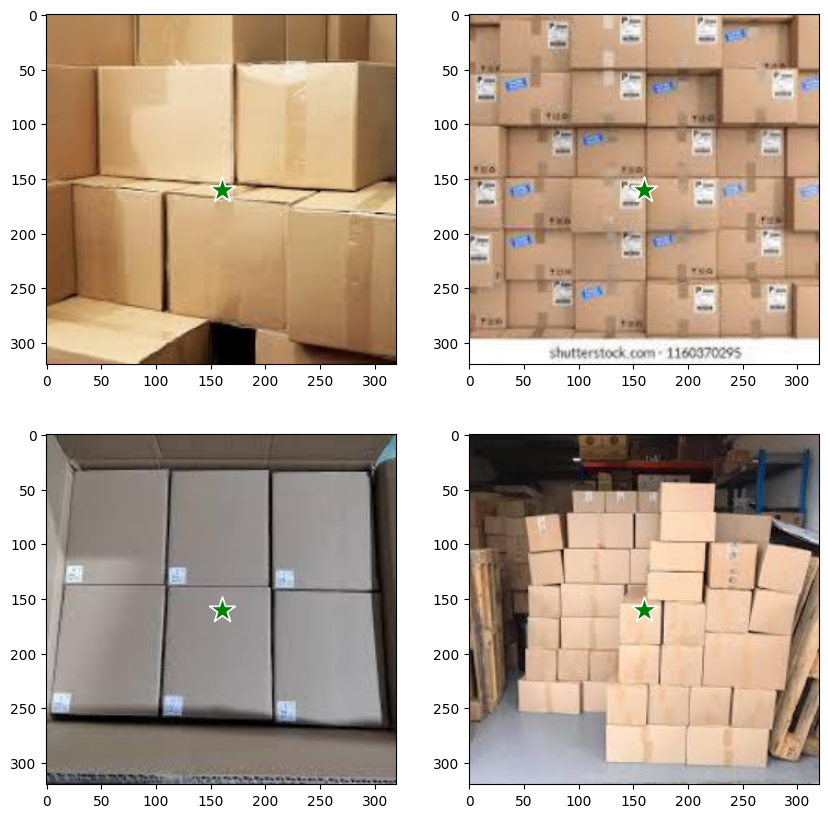

In [13]:
log(
    "testing",
    {bc(TARGET_SIZE, "x", TARGET_SIZE)},
    "images from",
    {bc(WILD_GUESSES[1], "to", WILD_GUESSES[1] + 4)},
)
plot_images_with_center_coords(*img_arr[WILD_GUESSES[1] : WILD_GUESSES[1] + 4])

___
# 2. Evaluating Models
---

## Evaluating FastSAM-x

log: FastSAM-x evaluation...



0: 320x320 13 objects, 175.2ms
Speed: 1.7ms preprocess, 175.2ms inference, 13.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 50 objects, 169.5ms
Speed: 1.0ms preprocess, 169.5ms inference, 9.5ms postprocess per image at shape (1, 3, 320, 320)


log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]



0: 320x320 18 objects, 175.8ms
Speed: 0.5ms preprocess, 175.8ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 58 objects, 144.4ms
Speed: 0.4ms preprocess, 144.4ms inference, 10.2ms postprocess per image at shape (1, 3, 320, 320)


log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]


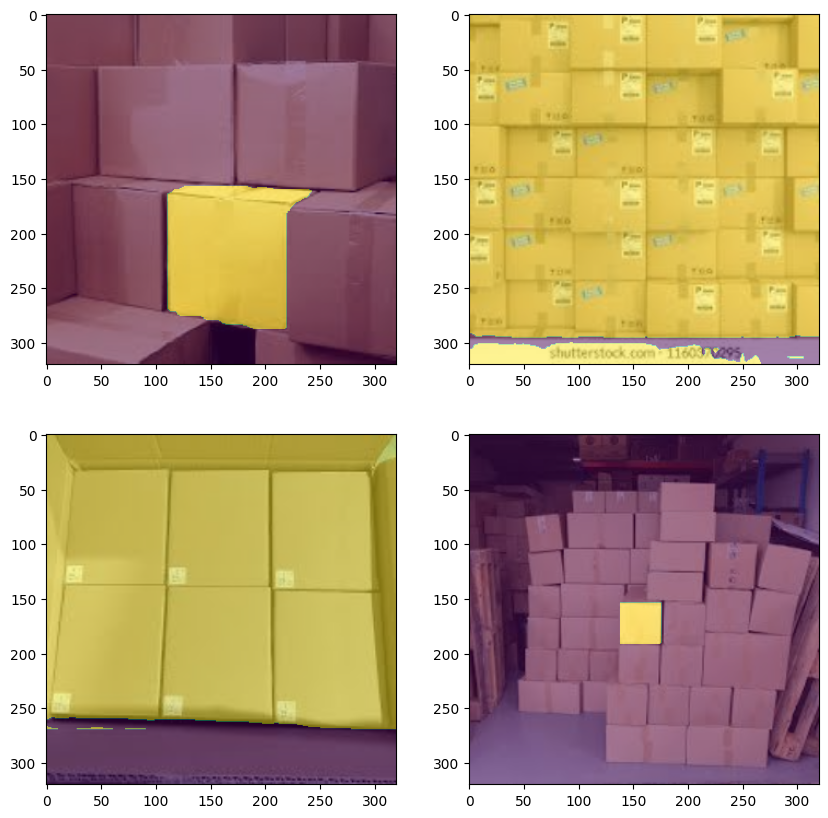

In [14]:
log(bg("FastSAM-x evaluation..."))
plot_images_with_mask(FASTSAM_X, *img_arr[WILD_GUESSES[1] : WILD_GUESSES[1] + 4])

## Evaluating FastSAM-s


0: 320x320 17 objects, 62.4ms
Speed: 0.5ms preprocess, 62.4ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 320)



log: FastSAM-s evaluation...
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]


0: 320x320 52 objects, 40.2ms
Speed: 0.4ms preprocess, 40.2ms inference, 6.2ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 17 objects, 42.1ms
Speed: 0.5ms preprocess, 42.1ms inference, 2.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 65 objects, 35.5ms
Speed: 0.4ms preprocess, 35.5ms inference, 10.5ms postprocess per image at shape (1, 3, 320, 320)


log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]


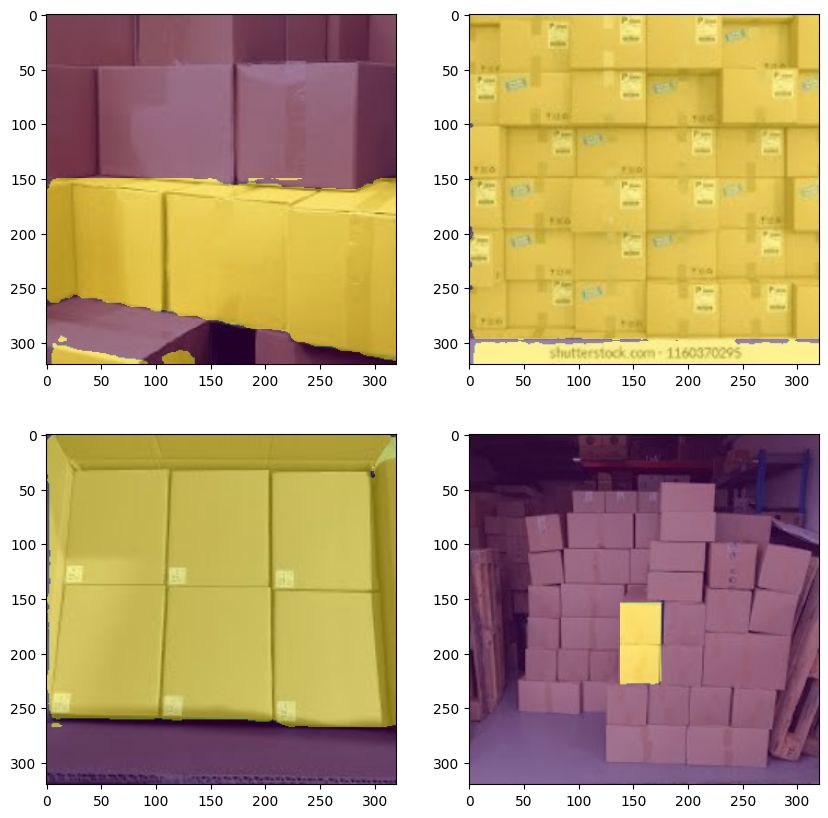

In [15]:
log(bg("FastSAM-s evaluation..."))
plot_images_with_mask(FASTSAM_S, *img_arr[WILD_GUESSES[1] : WILD_GUESSES[1] + 4])

## Evaluating SAM: WIP

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]

    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def fastsam_maskgen(
    model, image, device=device, retina_masks=True, imgsz=TARGET_SIZE, conf=0.4, iou=0.9
):
    """
    utility function to easily generate masks from FastSAM models
    """
    if model == FASTSAM_X:
        return FastSAMPrompt(
            image,
            model_fastsam_x(
                image,
                device=device,
                retina_masks=retina_masks,
                imgsz=imgsz,
                conf=conf,
                iou=iou,
            ),
            device=device,
        ).point_prompt(points=get_center_coords(image), pointlabel=[1])[0]
    elif model == FASTSAM_S:
        return FastSAMPrompt(
            image,
            model_fastsam_s(
                image,
                device=device,
                retina_masks=retina_masks,
                imgsz=imgsz,
                conf=conf,
                iou=iou,
            ),
            device=device,
        ).point_prompt(points=get_center_coords(image), pointlabel=[1])[0]
    else:
        return "Invalid model"


def plot_images_with_mask(model, image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].imshow(fastsam_maskgen(model, image1), alpha=0.5)
    ax[0, 1].imshow(image2)
    ax[0, 1].imshow(fastsam_maskgen(model, image2), alpha=0.5)
    ax[1, 0].imshow(image3)
    ax[1, 0].imshow(fastsam_maskgen(model, image3), alpha=0.5)
    ax[1, 1].imshow(image4)
    ax[1, 1].imshow(fastsam_maskgen(model, image4), alpha=0.5)
    plt.show()

log: Getting Center Coordinates...
log: Image resolution: 320x320
log: Center Coordinates: [160, 160]
log: (320, 320, 3)
log: SAM evaluation...


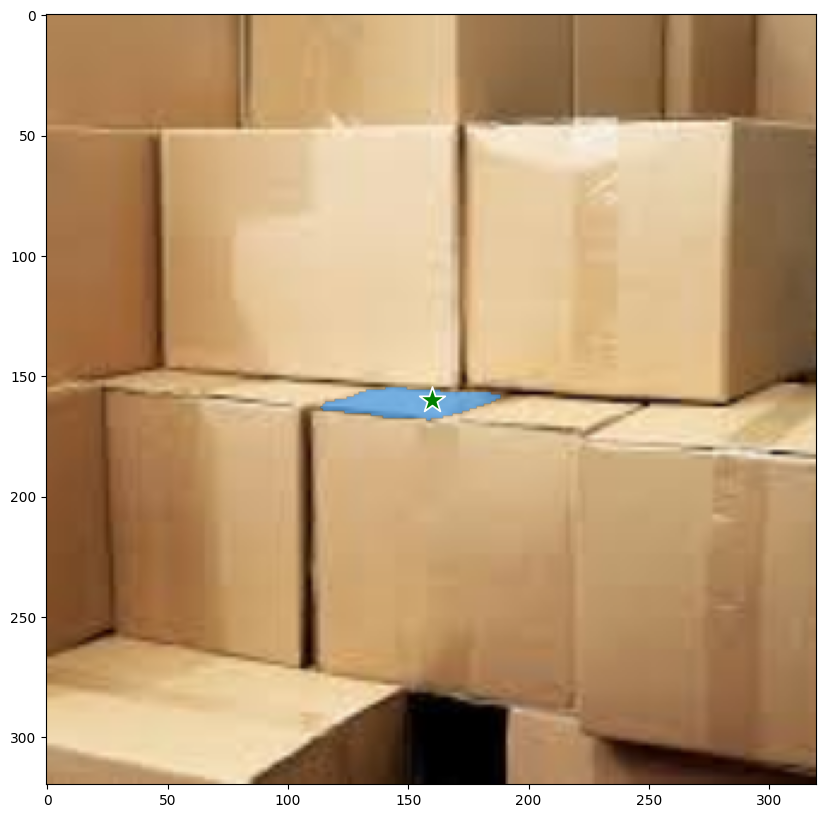


0: 320x320 17 objects, 61.4ms
Speed: 1.2ms preprocess, 61.4ms inference, 4.0ms postprocess per image at shape (1, 3, 320, 320)


(3, 320, 320)
(1, 320, 320)


In [21]:
if TESTING_SAM:
    testing_img = img_arr[WILD_GUESSES[1]]
    center_coords = get_center_coords(testing_img)
    log(testing_img.shape)
    log(bg("SAM evaluation..."))

    model_sam.set_image(testing_img)
    masks, scores, logits = model_sam.predict(
        point_coords=center_coords,
        point_labels=np.array([1]),
        multimask_output=True,
    )
    # plot the SAM mask over the image without using user defined functions
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(testing_img)
    show_mask(masks[0], ax)
    show_points(center_coords, np.array([1]), ax)
    plt.show()

    fastsam_mask = FastSAMPrompt(
        testing_img,
        model_fastsam_s(
            testing_img,
            device=device,
            retina_masks=True,
            imgsz=TARGET_SIZE,
            conf=0.4,
            iou=0.9,
        ),
        device=device,
    ).point_prompt(points=center_coords, pointlabel=[1])

    print(masks.shape)  # (number_of_masks) x H x W
    print(fastsam_mask.shape)

    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     plot_mask_with_score(image, i + 1, mask, score, input_point, input_label)

    # mask_with_highest_score, highest_score, logits_for_highest_score = (
    #     get_mask_with_highest_score(masks, scores, logits)
    # )

    # plot_mask_with_score(
    #     image, "best", mask_with_highest_score, highest_score, input_point, input_label
    # )

---
# Comparing FastSAM-x and FastSAM-s
---

In [ ]:
# x_mask = fastsam_maskgen(0, img_arr[0])
# s_mask = fastsam_maskgen(1, img_arr[0])

# # ANNOTATED_PATH = f"{ROOT}/annotate/box.jpg"
# # BUG: tkinter kernel crash, unexpected behavior
# # fast_sam_prompt_process.plot(annotations=mask,output_path=ANNOTATED_PATH)

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(x_mask, interpolation="none")
# ax[1].imshow(s_mask, interpolation="none")
# # show_mask(x_mask, ax[0])
# # show_mask(s_mask, ax[1])
# plt.show()


# TODO: utilize show_mask function to plot the masks
for i in range(4):
    plot_diff_masks(img_arr[i], 0, 1)

---
# Coordinate Detections
---

In [ ]:
wild_guess = randint(0, len(img_arr) - 1)
sample_image = img_arr[wild_guess]
sample_mask = fastsam_maskgen(1, sample_image)

if DETAILED_LOGS:
    print(f"Random Image: {wild_guess}")
    print(f"Image Array Element Type: {type(sample_image)}")
    print(f"Image Array Element Shape: {sample_image.shape}")
    print(f"Sample Mask Type: {type(sample_mask)}")
    print(f"Sample Mask Shape: {sample_mask.shape}")

# TODO: check whether below is needed
# ? The mask and the image are not in the correct matching dimensions. We have to map this one.
# reshaped_mask = np.transpose(sample_mask, (1, 2, 0))
# reshaped_mask.shape

In [ ]:
def plot_square(mask):
    # find the indices where the mask is true
    true_indices = np.argwhere(mask)
    # get the bounding box of the true region
    top_l = np.min(true_indices, axis=0)
    bot_r = np.max(true_indices, axis=0)
    # calculate the width and height of the bounding box
    w = bot_r[1] - top_l[1]
    h = bot_r[0] - top_l[0]

    fig, ax = plt.subplots(1)
    # plot the mask
    ax.imshow(mask, cmap="gray")
    # create a rectangle patch
    rect = patches.Rectangle(
        (top_l[1], top_l[0]), w, h, linewidth=2, edgecolor="r", facecolor="none"
    )
    # add the rectangle patch to the axis
    ax.add_patch(rect)
    plt.show()


# BUG: handle the case where the mask is empty

plot_square(sample_mask)

In [ ]:
def get_bounding_box_coordinates(mask):
    # find the indices where the mask is true
    true_indices = np.argwhere(mask)

    # get the bounding box of the true region
    top_l = np.min(true_indices, axis=0)
    bot_r = np.max(true_indices, axis=0)

    # calculate the width and height of the bounding box
    w = bot_r[1] - top_l[1]
    h = bot_r[0] - top_l[0]

    # calculate the coordinates of the corners
    top_r = (top_l[1] + w, top_l[0])
    bot_l = (top_l[1], top_l[0] + h)
    bot_r = (top_l[1] + w, top_l[0] + h)
    top_l = (top_r[0] - (bot_r[0] - bot_l[0]), (top_r[1] - bot_r[1]) + bot_l[1])

    if DETAILED_LOGS:
        print("Bounding Box Coordinates")
        print("Top left:", top_l)
        print("Top right:", top_r)
        print("Bottom left:", bot_l)
        print("Bottom right:", bot_r)

    return [top_l, top_r, bot_l, bot_r]


bound_coords = get_bounding_box_coordinates(sample_mask)

In [ ]:
def annotate_square_corners(
    image, top_left, top_right, bottom_left, bottom_right, save_path
):
    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the original image
    ax.imshow(image)

    # Annotate the corners
    ax.plot(top_left[0], top_left[1], "ro")  # Top Left corner
    ax.plot(top_right[0], top_right[1], "go")  # Top Right corner
    ax.plot(bottom_left[0], bottom_left[1], "bo")  # Bottom Left corner
    ax.plot(bottom_right[0], bottom_right[1], "yo")  # Bottom Right corner

    # Save the plot to the specified path
    plt.savefig(save_path)
    plt.show()


annotate_square_corners(
    sample_image,
    *get_bounding_box_coordinates(sample_mask),
    f"{ROOT}/annotate/box_img_{wild_guess}.jpg",
)

---
# Pipeline WIP
---

In [ ]:
def get_box_coordinates_fast_sam(
    image_path: str,
    model_path: str,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=True,
    showPlotMaskWithHighestScore=True,
):
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot original image
    if showOriginalImage:
        plot_image(img)

    # get image dimensions
    img_height, img_width, _ = img.shape

    # get centre point coordinates
    center_point_coords = [int(img_width / 2), int(img_height / 2)]
    input_point = np.array([center_point_coords])
    input_label = np.array([1])

    if showPoints:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        show_points(input_point, input_label, plt.gca())
        plt.axis("on")
        plt.show()

    # draw a rectangle that makes the center point of image

    # generate the mask in the relevant area
    if isFastSAM:
        model_fast_sam = FastSAM(model_path)
        fast_sam_predictor = model_fast_sam(
            img,
            device=device,
            retina_masks=True,
            imgsz=img_width,
            conf=0.4,
            iou=0.9,
        )
        fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)

        # point prompt
        # points default [[0,0]] [[x1,y1],[x2,y2]]
        # point_label default [0] [1,0] 0:background, 1:foreground
        img_mask = fast_sam_prompt_process.point_prompt(
            points=input_point, pointlabel=input_label
        )

        # plot_mask_with_score(img, "FastSAM output", img_mask, input_point, input_label )

        # reshape image mask
        # print(img_mask.shape)
        img_mask = np.transpose(img_mask, (1, 2, 0))
        # print(img_mask.shape)

    if showPlotMaskWithHighestScore:
        plot_square(img_mask)

    # get the rectangular boxes
    img_top_left, img_top_right, img_bottom_left, img_bottom_right = (
        get_bounding_box_coordinates(img_mask)
    )

    # get the coordinates of the rectangular bounding box
    annotate_square_corners(
        img,
        img_top_left,
        img_top_right,
        img_bottom_left,
        img_bottom_right,
        "/content/annotated_box_image.jpg",
    )

In [ ]:
time_list = []

# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(
    img_paths[5],
    model_path=fast_sam_x_checkpoint,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=False,
    showPlotMaskWithHighestScore=True,
)

time_list.append(time.time() - start_time)
print(f"Time taken for operation : {time_list[-1]}")

___
# Benchmarking WIP
___

In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(
    img_paths[5],
    model_path=fast_sam_s_checkpoint,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=False,
    showPlotMaskWithHighestScore=False,
)

time_list.append(time.time() - start_time)
print(f"Time taken for operation : {time_list[-1]}")

In [ ]:
time_list = []

In [ ]:
output_images_path = "/content/drive/MyDrive/annotated_boxes_fast_sam/"

In [ ]:
try:
    os.makedirs(output_images_path)
except FileExistsError:
    print("folder already exists")

In [ ]:
def get_box_coordinates_updated(
    image_path: str,
    showOriginalImage=False,
    showPoints=True,
    showMasksWithScores=True,
    showPlotMaskWithHighestScore=True,
):
    img_name = image_path.split("/")[-1]
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot original image
    if showOriginalImage:
        plot_image(img)

    # get image dimensions
    img_height, img_width, _ = img.shape

    # get centre point coordinates
    center_point_coords = [int(img_width / 2), int(img_height / 2)]
    input_point = np.array([center_point_coords])
    input_label = np.array([1])

    if showPoints:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        show_points(input_point, input_label, plt.gca())
        plt.axis("on")
        plt.show()

    # draw a rectangle that makes the center point of image

    # generate masks in the relevant area
    predictor.set_image(img)

    img_masks, img_masks_scores, img_masks_logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    if showMasksWithScores:
        for i, (mask, score) in enumerate(zip(img_masks, img_masks_scores)):
            plot_mask_with_score(img, i + 1, mask, score, input_point, input_label)

    # get the mask with the highest score
    (
        img_mask_with_highest_score,
        img_mask_highest_score,
        img_mask_logits_for_highest_score,
    ) = get_mask_with_highest_score(img_masks, img_masks_scores, img_masks_logits)

    if showPlotMaskWithHighestScore:
        plot_square(img_mask_with_highest_score)

    # get the rectangular boxes
    img_top_left, img_top_right, img_bottom_left, img_bottom_right = (
        get_bounding_box_coordinates(img_mask_with_highest_score)
    )

    # get the coordinates of the rectangular bounding box

    annotate_square_corners(
        img,
        img_top_left,
        img_top_right,
        img_bottom_left,
        img_bottom_right,
        output_images_path + img_name,
    )

In [ ]:
get_box_coordinates_updated(
    img_paths[0],
    showOriginalImage=False,
    showPoints=False,
    showMasksWithScores=False,
    showPlotMaskWithHighestScore=False,
)

In [ ]:
updated_time_list = []

In [ ]:
for img_path in img_paths:
    # start_time = time.time()
    get_box_coordinates_updated(
        img_path,
        showOriginalImage=False,
        showPoints=False,
        showMasksWithScores=False,
        showPlotMaskWithHighestScore=False,
    )

    # updated_time_list.append(time.time()-start_time)
    # print(f"Time taken for operation : {time_list[-1]}")

In [ ]:
updated_avg_time = sum(updated_time_list) / len(img_paths)
print("Average time for inference :", updated_avg_time, " s")